# Social Network Analysis
## Instagram Mapping
Student:
* Jesus Catzin Cetz 1809036

In [16]:
# Importing libraries
import networkx as nx
import chromedriver_binary
from collections import defaultdict
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
# from selenium.interactions import Actions
import selenium
import random
import time
import re
import collections
import sys
import json
import numpy
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

In [2]:
def read_creds(filename):
    '''
    Store API credentials in a safe place.
    Input: String of the user name and password
    Output: Return the credential strings
    '''
    with open(filename) as f:
        credentials = json.load(f)
    return credentials

def saveData(path, data):
    """
    Store the Data collected.
    Input: The path to save it, and the data.
    Output: Data Saved into a Json File
    """
    with open(path, 'w', encoding='utf-8') as file:
        json.dump(data, file, ensure_ascii = False, indent = 4 )
    file.close()    

In this case the credential were saved into a txt file and not provided to run the notebook due privacy for the user, if you desire to run it provided your username and password.

In [3]:
# Reading Credential (User and Password)
data = read_creds("credentials.txt")

In [4]:
# Directions to go into the instagram main page
main = "https://www.instagram.com/?hl=es"
# Directions to go into the instagram profile page
main_profile = "https://www.instagram.com/%s/"

In [5]:
# Calling the browser
driven = webdriver.Chrome()

In [6]:
# Going to the direction.
driven.get(main)
driven.implicitly_wait(5)

In [7]:
#write your username and password
elementID = driven.find_element_by_xpath('//*[@id="loginForm"]/div/div[1]/div/label/input')
elementID.send_keys(data["username"])

elementID = driven.find_element_by_xpath('//*[@id="loginForm"]/div/div[2]/div/label/input')
elementID.send_keys(data["password"])

# #submit form
elementID.submit()
time.sleep(5)

Before run the following functions it is important to consider that it could not work in your instagram profile because the structure of the main profile page changes. This function can work with some variations which are the following, find which structure have your profile and change it, if no one works in your, you have to implement yours: 
* '/html/body/div[5]/div/div/div[2]/ul/div/li[1]/'
* 'div/div[2]/div[1]/div/div/span/a'
* 'div/div[1]/div[2]/div[1]/span/a'
* 'div/div[2]/div[1]/div/div/span/a'

In [95]:
def get_followers(browser, link, username):
    '''
    Fuction toget the people that you follow. 
    Input:
    * Browser: The browser you want to use to make the scraping (Chrome, Edge, Opera etc)
    * Link: The main profile page of instagram
    * Username
    Output return usernames of people that follow you (Dictionary and lists)
    '''
    link = link % username
    browser.get(link)
    time.sleep(3)
    browser.find_element_by_xpath('//*[@id="react-root"]/section/main/div/header/section/ul/li[2]/a').click()
    element = browser.find_element_by_class_name('isgrP')
#     contacts = browser.find_elements_by_class_name('wo9IH')
    contacts = browser.find_element_by_class_name('PZuss')
    contacts = contacts.find_elements_by_tag_name('li')
    
#     number_of_contacts = browser.find_element_by_xpath('//*[@id="react-root"]/section/main/div/header/section/ul/li[2]/a/span')
#     number_of_contacts = int(number_of_contacts.text.replace(",", ""))
    number_of_contacts = 0
    
    while len(contacts) != number_of_contacts and len(contacts) < 100:
        browser.execute_script("arguments[0].scrollBy(0,1000)", element)
        time.sleep(1)
#         contacts = browser.find_elements_by_class_name('wo9IH')
        number_of_contacts = len(contacts)
        contacts = browser.find_element_by_class_name('PZuss')
        contacts = contacts.find_elements_by_tag_name('li')
        
    usernames = []
    
    for profile in contacts:
#         /html/body/div[5]/div/div/div[2]/ul/div/li[1]/
# T        'div/div[2]/div[1]/div/div/span/a'
# C        'div/div[1]/div[2]/div[1]/span/a'
# C        'div/div[2]/div[1]/div/div/span/a'
        username = profile.find_element_by_xpath('div/div[1]/div[2]/div[1]/span/a').get_attribute("title")
        usernames.append(username)
    
    return usernames

def get_following(browser, link, username):
     '''
    Fuction toget the people that you follow. 
    Input:
    * Browser: The browser you want to use to make the scraping (Chrome, Edge, Opera etc)
    * Link: The main profile page of instagram
    * Username
    Output return usernames of people that you follow (Dictionary and lists)
    '''
    link = link % username
    browser.get(link)
    time.sleep(3)
    browser.find_element_by_xpath('//*[@id="react-root"]/section/main/div/header/section/ul/li[3]/a').click()
    element = browser.find_element_by_class_name('isgrP')
    # contacts = browser.find_elements_by_class_name('wo9IH')
    
    profiles = browser.find_element_by_class_name('PZuss')
    profiles = profiles.find_elements_by_tag_name('li')
    
#     number_of_profiles = browser.find_element_by_xpath('//*[@id="react-root"]/section/main/div/header/section/ul/li[3]/a/span')
#     number_of_profiles = int(number_of_profiles.text.replace(",", ""))
    
    number_of_profiles = 0
    while len(profiles) != number_of_profiles and len(profiles) < 100:
        browser.execute_script("arguments[0].scrollBy(0,1000)", element)
        time.sleep(1)
#         contacts = browser.find_elements_by_class_name('wo9IH')
        number_of_profiles = len(profiles)
        profiles = browser.find_element_by_class_name('PZuss')
        profiles = profiles.find_elements_by_tag_name('li')
    
    usernames = []
    
    for profile in profiles:

# C        div/div[1]/div[2]/div[1]/span/a
# T        div/div[1]/div[2]/div[1]/span/a

        username = profile.find_element_by_xpath('div/div[1]/div[2]/div[1]/span/a').get_attribute("title")
        usernames.append(username)
    
    return usernames

In [98]:

def enrichData(browser, link, root, idy = 0):
    """
    It makes the connections between the followers and followings of the user. 
    For example it starts with a user name, and start to find inside the data the connections and so on. 
    For example starts with a user name: alex, find its contacts, and then check the following contact 
    inside it, and so on.
    """
    enrich_root = []
    enrich_root.extend(root)
    
    for idx, profile in enumerate(root[0]["followers"][idy:]):
        
#         print(profile)
        # Mapping and making the network
        followers = get_followers(browser, link, profile)
        following = get_following(browser, link, profile)
        
        user_information = {
            "username" : profile,
            "followers" : followers,
            "following": following
        }
        
        enrich_root.append(user_information)
        
        saveData('network/{}.json'.format(idx + idy), enrich_root)
        
    return enrich_root

In [72]:
#Get followers
followers = get_followers(driven, main_profile, data["username"])

In [77]:
#Get following
following = get_following(driven, main_profile, data["username"])

In [82]:
root_profile = [
    {
        "username" : data["username"],
        "followers" : followers,
        "following": following
    }
]

In [83]:
# To save the data in case the mapping gets broken.
#saveData("root.json", root_profile)

In [99]:
enrichData(driven, main_profile, root_profile, idy = 0)

## Network

In [2]:
# Opening, loading and closing the data got from the web scraping.
data = open("50.json")
data_ = json.load(data)
data.close()

In [3]:
G = nx.Graph()

In [4]:
for acount in data_:
    for sub_a in acount["followers"]:
        G.add_edge(sub_a, acount["username"])
    for sub_b in acount["following"]:
        G.add_edge(acount["username"], sub_b)

In [5]:
user = { user: idx for idx, user in enumerate(G.nodes()) }

In [6]:
G_censored = nx.Graph()

In [7]:
for acount in data_:
    for sub_a in acount["followers"]:
        G_censored.add_edge(
            user[sub_a], 
            user[acount["username"]]
        )
    for sub_b in acount["following"]:
        G_censored.add_edge(
            user[acount["username"]],
            user[sub_b]
        )

In [8]:
nx.write_edgelist(G_censored, "instagram_network.csv", delimiter=",")

In [9]:
G = nx.read_edgelist("instagram_network.csv",
                       delimiter=",")

In [10]:
pos = nx.spring_layout(G)

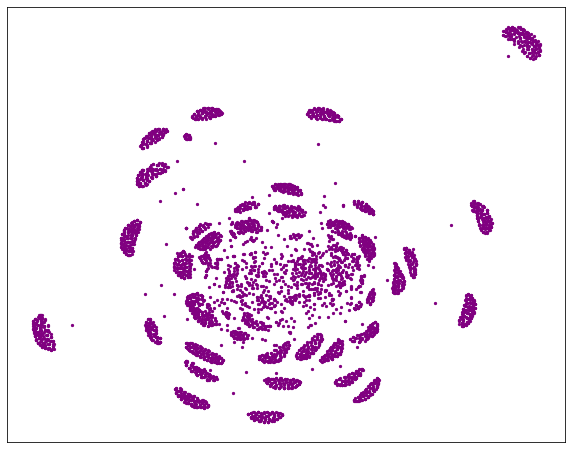

In [11]:
fig, ax = plt.subplots(figsize = (10, 8))

nx.draw_networkx_nodes(G, pos = pos,
                       node_size = 5, 
                       node_color="purple",
                       ax = ax)
plt.savefig("fig1.png", dpi=150)
plt.show()

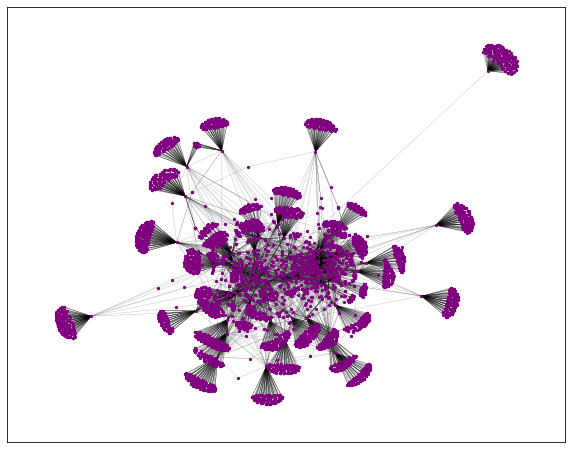

In [12]:
fig, ax = plt.subplots(figsize = (10, 8))

nx.draw_networkx_nodes(G, pos = pos,
                       node_size = 5, 
                       node_color="purple",
                       ax = ax)

nx.draw_networkx_edges(G, pos = pos,
                       edgelist = G.edges,
                       edge_color = "black",
                       width = 0.1,
                       ax = ax)
plt.savefig("fig2.png", dpi=150)
plt.show()

### Basic characteristics of the network

In [13]:
N = G.number_of_nodes()
L = G.number_of_edges()
density = nx.density(G)
radius = nx.radius(G)
diameter = nx.diameter(G)
ASPL = nx.average_shortest_path_length(G)
ACC = nx.average_clustering(G)

In [14]:
print("Number of Nodes => %d" % N )
print("Number of Edges => %d" % L )
print("Density => %0.6f" % density )
print("Network's radius => %d" % radius )
print("Network's diameter => %d" % diameter )
print("Average Path Lenght => %0.3f" % ASPL )
print("Clustering Coefficient => %0.3f" % ACC )

Number of Nodes => 4948
Number of Edges => 6869
Density => 0.000561
Network's radius => 2
Network's diameter => 4
Average Path Lenght => 3.735
Clustering Coefficient => 0.075


### Degree Distribution


In [17]:
degree_distribution = list( dict(G.degree()).values() )
min_degree = np.min(degree_distribution)
max_degree = np.max(degree_distribution)
average_degree = np.mean(degree_distribution)

In [18]:
print("Minimum Degree %d" % min_degree)
print("Maximum Degree %d" % max_degree)
print("Average Degree %0.3f" % average_degree)

Minimum Degree 1
Maximum Degree 203
Average Degree 2.776


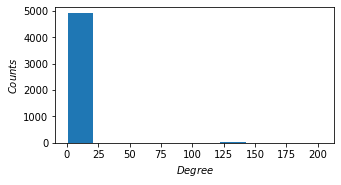

In [19]:
fig, ax = plt.subplots(figsize = (5, 2.5))

ax.hist(degree_distribution)

ax.set_xlabel("$Degree$")
ax.set_ylabel("$Counts$")

plt.savefig("DegreeDistribution.png", dpi = 200)

In [20]:
degree_distribution_Counter = np.array( [ list(x) for x in Counter(degree_distribution).items() ])

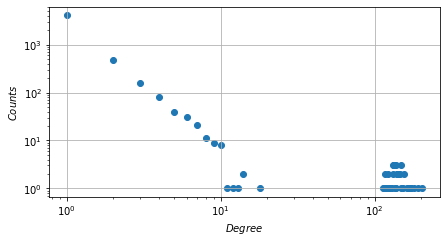

In [21]:
fig, ax = plt.subplots(figsize = (7, 3.5))

ax.scatter(degree_distribution_Counter[:, 0], degree_distribution_Counter[:, 1])

ax.set_xlabel("$Degree$")
ax.set_ylabel("$Counts$")

ax.set_yscale("log")
ax.set_xscale("log")

ax.grid()

plt.savefig("DegreeDistributionScale.png", dpi = 200)

### Link Prediction

In [22]:
def top_links_predict(iterable):
    #result = {(u, v):p for u,v,p in iterable}
    return sorted(iterable,key = lambda x: x[2], reverse = True)[:100]

### Jaccard Coefficient

In [23]:
jaccard_coefficient = nx.jaccard_coefficient(G)


In [24]:
jacc_result = top_links_predict(jaccard_coefficient)
jacc_result[:10]

[('2329', '2308', 1.0),
 ('2329', '2271', 1.0),
 ('2329', '2295', 1.0),
 ('2329', '2301', 1.0),
 ('2329', '2334', 1.0),
 ('2329', '2297', 1.0),
 ('2329', '2302', 1.0),
 ('2329', '2291', 1.0),
 ('2329', '2283', 1.0),
 ('2329', '2280', 1.0)]

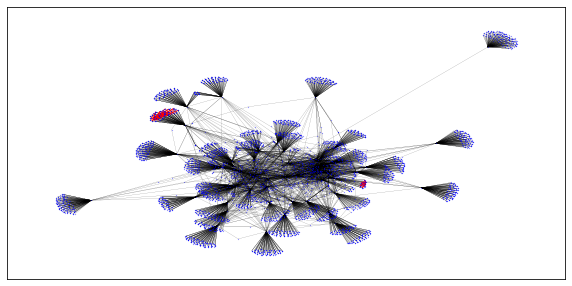

In [25]:
fig, ax = plt.subplots( figsize = (10, 5) )

nx.draw_networkx(G, pos, with_labels = False,
                 node_color = "blue",
                 node_size = 0.025,
                 width = 0.1,
                 ax = ax)

nx.draw_networkx_edges(G, pos,
                       edgelist = jacc_result,
                       edge_color = "red",
                       width = 0.5,
                       ax = ax)
plt.savefig("jac.png")
plt.show()

### Resource Allocation

In [26]:
resource = nx.resource_allocation_index(G)


In [27]:
res_all = top_links_predict(resource)
res_all[:10]

[('50', '38', 11.680840762629806),
 ('50', '4', 10.68917409596314),
 ('24', '38', 8.943573797678273),
 ('4', '38', 8.428459810248853),
 ('22', '38', 6.420954750059227),
 ('11', '28', 6.3794856833924385),
 ('4', '24', 6.315088470054074),
 ('34', '31', 5.871186277920489),
 ('50', '22', 5.649923004027482),
 ('31', '38', 5.394764273868752)]

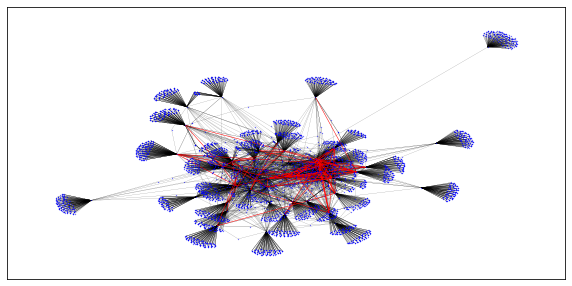

In [28]:
fig, ax = plt.subplots( figsize = (10, 5) )

nx.draw_networkx(G, pos, with_labels = False,
                 node_color = "blue",
                 node_size = 0.05,
                 width = 0.1,
                 ax = ax)

nx.draw_networkx_edges(G, pos,
                       edgelist = res_all,
                       edge_color = "red",
                       width = 0.5,
                       ax = ax)
plt.savefig("resource.png")
plt.show()

### Adamic Adar

In [29]:
adamic = nx.adamic_adar_index(G)

In [30]:
adamic_result = top_links_predict(adamic)
adamic_result[:10]

[('50', '38', 36.741345189001834),
 ('50', '4', 33.843180299833655),
 ('24', '38', 27.48265083052755),
 ('4', '38', 27.01535084641169),
 ('11', '28', 20.909949887311917),
 ('22', '38', 20.32254223629937),
 ('4', '24', 20.230025557833496),
 ('34', '31', 18.195794424907383),
 ('50', '22', 18.099642122722244),
 ('33', '38', 17.14691794407945)]

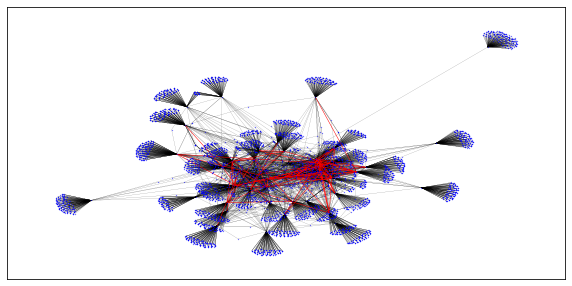

In [31]:
fig, ax = plt.subplots( figsize = (10, 5) )

nx.draw_networkx(G, pos, with_labels = False,
                 node_color = "blue",
                 node_size = 0.05,
                 width = 0.1,
                 ax = ax)

nx.draw_networkx_edges(G, pos,
                       edgelist = adamic_result,
                       edge_color = "red",
                       width = 0.5,
                       ax = ax)
plt.savefig("adamic.png")
plt.show()

### Preferential Attachment Mechanism

In [32]:
pref_att = nx.preferential_attachment(G)

In [33]:
pref_result = top_links_predict(pref_att)
pref_result[:10]

[('42', '27', 39179),
 ('42', '43', 36540),
 ('42', '13', 34916),
 ('43', '27', 34740),
 ('42', '36', 34510),
 ('42', '30', 34307),
 ('42', '9', 33698),
 ('27', '13', 33196),
 ('42', '47', 32886),
 ('27', '36', 32810)]

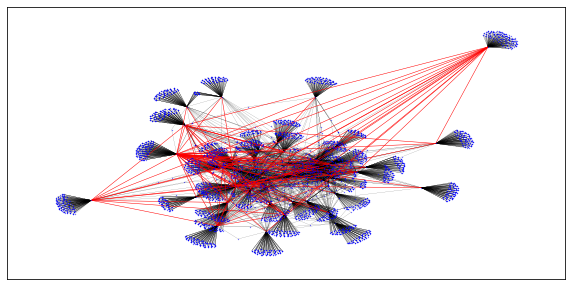

In [34]:
fig, ax = plt.subplots( figsize = (10, 5) )

nx.draw_networkx(G, pos, with_labels = False,
                 node_color = "blue",
                 node_size = 0.05,
                 width = 0.1,
                 ax = ax)

nx.draw_networkx_edges(G, pos,
                       edgelist = pref_result,
                       edge_color = "red",
                       width = 0.5,
                       ax = ax)
plt.savefig("preferential.png")
plt.show()